# Chapter 6 -Standardise + Data curation

Data curation in cheminformatics is a process of standardizing and correcting chemical files to make it suitable for further use. This process is crucial in any cheminformatics task, since failure to conduct an appropriate data curation will most certainly jeopardize the whole research at the early stage. Data curation can be divided into two major categories: structure data curation and property (activity) data curation.

- The goal of structure data curation is to modify structure representation in the file, so that it is correct from the chemistry point of view
- The goal of property data curation is to modify compound data in the file, so that it is correct and homogenous

See here for my own notes

https://github.com/MARC0041/HTX_ChemScreen/blob/main/src/dataprep/curate.py 

In [25]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors, rdMolDescriptors, GraphDescriptors
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
import copy
import numpy as np
import pandas as pd
import pickle

from rdkit.Chem.MolStandardize import rdMolStandardize

from IPython.display import Image
from IPython.display import SVG

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)

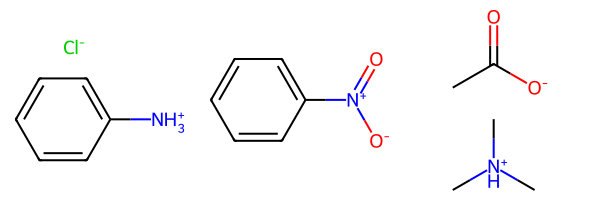

In [11]:
# charge standardisation
s1 = 'c1ccccc1[NH3+].[Cl-]'
s2 = 'c1ccccc1[N+](=O)[O-]'
s3 = 'C[NH+](C)C.CC(=O)[O-]'

mol_charge_standardised = []
uncharger = rdMolStandardize.Uncharger()
for s in [s1,s2,s3]:
    mol = Chem.MolFromSmiles(rdMolStandardize.StandardizeSmiles(s))
    mol = uncharger.uncharge(mol)
    mol_charge_standardised.append(mol)
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in [s1,s2,s3]])


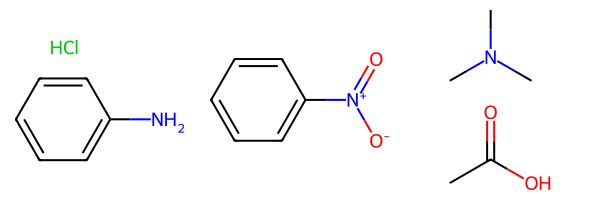

In [13]:
Draw.MolsToGridImage(mol_charge_standardised)

In [ ]:
# Get canonical tautomer (e.g. enol)
# rdMolStandardize.CanonicalTautomer(mol)

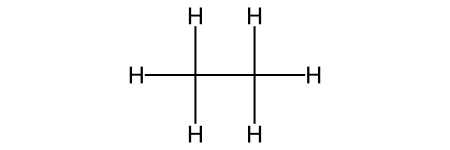

In [18]:
# hydrogen standardisation
mol_ethane = Chem.AddHs(Chem.MolFromSmiles("CC"))
# Chem.RemoveHs(mol_ethane)
mol_ethane

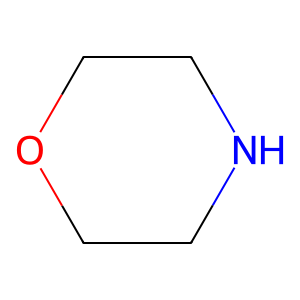


     RDKit          3D

 15 15  0  0  0  0  0  0  0  0999 V2000
    0.0920    1.2592    0.2162 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.2563    0.4684    0.0464 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.0388   -0.9589   -0.2167 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2446   -1.4055   -0.3834 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2004   -0.7638    0.3519 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.1712    0.6901    0.0317 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.1866    2.1360    0.6940 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.8545    0.9568   -0.7530 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.8782    0.5952    0.9823 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.5727   -1.2456   -1.1726 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.5305   -1.6042    0.5480 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2011   -0.9982    1.4345 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.1903   -1.1466   -0.0187 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.9326    1.2286    0

In [28]:
# conformer generation
smi_morpholine = "N1CCOCC1"
mol_morpholine = Chem.MolFromSmiles(smi_morpholine)
img1 = Draw.MolToImage(mol_morpholine)
display(img1)
mol_morpholine = Chem.AddHs(mol_morpholine)
AllChem.Compute2DCoords(mol_morpholine)
AllChem.EmbedMolecule(mol_morpholine) # generate 3d coordinates
print(Chem.MolToMolBlock(mol_morpholine))


In [ ]:
# complete standardisation

def standardise_function(chemdata):
    uncharger = rdMolStandardize.Uncharger()
    standardised = []

    for mol in chemdata:
        newmol = rdMolStandardize.FragmentParent(mol)
        newmol = uncharger.uncharge(newmol)
        newmol = rdMolStandardize.CanonicalTautomer(newmol)
        newmol = rdMolStandardize.StereoParent(newmol)
        standardised.append(newmol)
    return standardised

chemlist_df_std = standardise_function(chemlist_df['Mol'])
chemlist_df['std'] = chemlist_df_std

# remove duplicates
smi_list = []
dup_list = []
for i in range(0,len(chemlist_df)):
    s = Chem.MolToSmiles(chemlist_df['std'][i])
    if s in smi_list:
        dup_list.append(chemlist_df.index[i])
    else:
        smi_list.append(s)

chemlist_df.loc[~chemlist_df.index.isin(dup_list)]

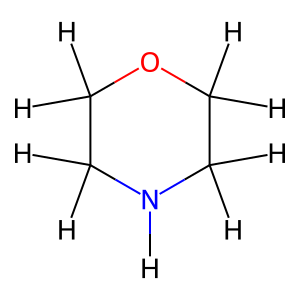

Matches for SMARTS pattern 'C-O': ((2, 3), (4, 3))


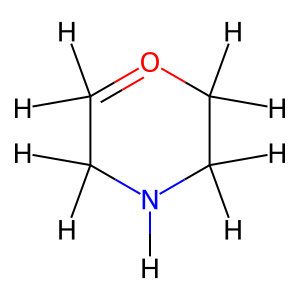

In [29]:
# alternative standardisation

# Import necessary RDKit modules
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import Image, display

# 1. Create a molecule from SMILES
smi_morpholine = "N1CCOCC1"
mol_morpholine = Chem.MolFromSmiles(smi_morpholine)

# 2. Add hydrogens to the molecule
mol_morpholine = Chem.AddHs(mol_morpholine)

# 3. Visualize the original molecule
img = Draw.MolToImage(mol_morpholine)
display(img)

# 4. Create a SMARTS query
query_smarts = "C-O"
query_mol = Chem.MolFromSmarts(query_smarts)

# 5. Find matches in the molecule
matches = mol_morpholine.GetSubstructMatches(query_mol)
print("Matches for SMARTS pattern 'C-O':", matches)

# 6. Modify the molecule using EditableMol
editable_mol = Chem.EditableMol(mol_morpholine)

# Find the bond to modify (e.g., a single bond between carbon and oxygen)
bond_to_modify = None
for bond in mol_morpholine.GetBonds():
    if bond.GetBondType() == Chem.BondType.SINGLE and \
       bond.GetBeginAtom().GetSymbol() == 'C' and \
       bond.GetEndAtom().GetSymbol() == 'O':
        bond_to_modify = bond
        break

if bond_to_modify:
    # Remove the existing bond
    editable_mol.RemoveBond(bond_to_modify.GetBeginAtom().GetIdx(),
                            bond_to_modify.GetEndAtom().GetIdx())
    # Add a double bond
    editable_mol.AddBond(bond_to_modify.GetBeginAtom().GetIdx(),
                         bond_to_modify.GetEndAtom().GetIdx(),
                         Chem.BondType.DOUBLE)

# Get the modified molecule
modified_mol = editable_mol.GetMol()

# 7. Visualize the modified molecule
img_modified = Draw.MolToImage(modified_mol)
display(img_modified)

# 8. Save the modified molecule to an SDF file
# writer = Chem.SDWriter('modified_morpholine.sdf')
# writer.write(modified_mol)
# writer.close()

Summary of Learning Points for Cheminformatics Standardization in KNIME:

# KNIME's Standardization Nodes with RDKit:

Recognize that KNIME's standardization nodes for RDKit may have limitations.

Explore the KNIME community for additional plugins or nodes that offer more functionality.

# Using Key Nodes:

Structure Normalizer: Use this node for cleanup tasks, such as neutralizing ionized compounds.

Salt Stripper: Effective for removing salt components from molecular structures, particularly useful for molecules with ionic compounds.

# Molecular Representation Formats:

Understand the differences between formats like Mol blocks and SDF files.

Know that SDF files are natively recognized by KNIME, allowing for immediate visualization, whereas Mol blocks may require rendering.

# Advanced Standardization Tasks:

Consider using Jupyter notebooks for more sophisticated standardization processes.

Explore the integration of KNIME with Jupyter notebooks for enhanced workflows.

# Molecular Representation Implications:

Be aware of the impact of explicit and implicit representations, such as aromatic bonds, on data processing and interpretation.

Recognize that changes in representation can affect downstream analyses like docking studies or QSAR modeling.

